In [0]:
!pip install -U git+https://github.com/albu/albumentations > /dev/null && echo "All libraries are successfully installed!"

  Running command git clone -q https://github.com/albu/albumentations /tmp/pip-req-build-5e5sue1h
All libraries are successfully installed!


In [0]:
from torchvision import datasets
train = datasets.CIFAR10('./data', train=True, download=True)

Files already downloaded and verified


In [0]:
from tqdm import tqdm_notebook
from PIL import Image
import numpy as np
n = 0
s = np.zeros(3)
sq = np.zeros(3)
for data, l in tqdm_notebook(train):
  x = np.array(data)/255
  s += x.sum(axis=(0,1))
  sq += np.sum(np.square(x), axis=(0,1))
  n += x.shape[0]*x.shape[1]

mu = s/n
std = np.sqrt((sq/n - np.square(mu)))
print(mu, sq/n, std, n)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  import sys



[0.49139968 0.48215841 0.44653091] [0.30249857 0.29176174 0.26781806] [0.24703223 0.24348513 0.26158784] 51200000


In [0]:
import sys
sys.path.append('/content/drive/My Drive/EVA4')

# Data Transformations with **Albumentations**

In [0]:
import numpy as np
from evadatatransforms import AlbumentationTransforms
import albumentations as A

channel_means = (0.49139968, 0.48215841, 0.44653091)
channel_stdevs = (0.24703223, 0.24348513, 0.26158784)
# Train Phase transformations

train_transforms = AlbumentationTransforms([
                                       A.Rotate((-30.0, 30.0)),
                                       A.HorizontalFlip(),
                                       A.RGBShift(r_shift_limit=50, g_shift_limit=50, b_shift_limit=50, p=0.5),
                                       A.Normalize(mean=channel_means, std=channel_stdevs),
                                       A.Cutout(num_holes=4) # fillvalue is 0 after normalizing as mean is 0
                                       ])

fillmeans = (np.array(channel_means)).astype(np.uint8)



# Test Phase transformations
test_transforms = AlbumentationTransforms([A.Normalize(mean=channel_means, std=channel_stdevs)])


# Loading and Split Datasets into Train and Test

In [0]:
from torchvision import datasets
train = datasets.CIFAR10('./data', train=True, download=True, transform=train_transforms)
test = datasets.CIFAR10('./data', train=False, download=True, transform=test_transforms)

Files already downloaded and verified
Files already downloaded and verified


In [0]:
import dataloaders

dataloader = dataloaders.DataLoader(batch_size=128)

# train dataloader
train_loader = dataloader.load(train)

# test dataloader
test_loader = dataloader.load(test)

In [0]:
import numpy as np
dataiter = iter(train_loader)
images, labels = dataiter.next()
i = images[90].numpy()
print(np.max(i), np.min(i))

1.598475 -1.9802378


torch.Size([128, 3, 32, 32])
torch.Size([128])


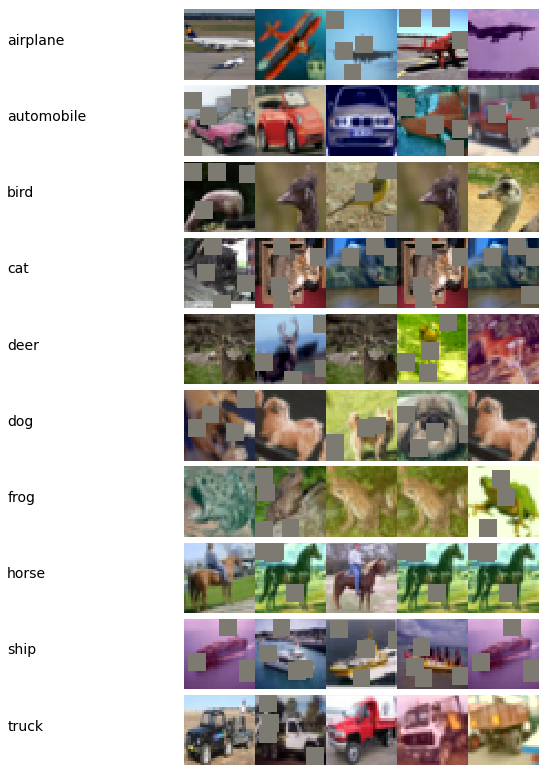

In [0]:
from __future__ import print_function
def unnormalize(img):
  img = img.numpy().astype(dtype=np.float32)
  
  for i in range(img.shape[0]):
    img[i] = (img[i]*channel_stdevs[i])+channel_means[i]
  
  return np.transpose(img, (1,2,0))

%matplotlib inline
import matplotlib.pyplot as plt
dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

num_classes = 10
# display 10 images from each category. 
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
r, c = 10, 11
n = 5
fig = plt.figure(figsize=(14,14))
fig.subplots_adjust(hspace=0.01, wspace=0.01)
for i in range(num_classes):
    idx = np.random.choice(np.where(labels[:]==i)[0], n)
    ax = plt.subplot(r, c, i*c+1)
    ax.text(-1.5, 0.5, class_names[i], fontsize=14)
    plt.axis('off')
    for j in range(1, n+1):
      plt.subplot(r, c, i*c+j+1)
      plt.imshow(unnormalize(images[idx[j-1]]), interpolation='none')
      plt.axis('off')
plt.show()

# **Model Summary**

In [0]:
import resnetmodel
import torch

model = resnetmodel.ResNet18()
use_cuda = torch.cuda.is_available()
model.device = torch.device("cuda" if use_cuda else "cpu")
model.to(model.device)
model.summary((3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1, 128,

# **LR_Finder**

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()



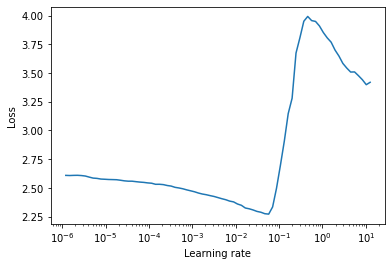

In [0]:

from lrfinder import LRFinder
import torch.optim as optim
import torch.nn as nn

L1lambda = 0
L2lambda = 1e-4
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-7, momentum=0.9, nesterov=True, weight_decay=L2lambda)
lr_finder = LRFinder(model, optimizer, criterion, device=model.device)
lr_finder.range_test(train_loader, end_lr=100, num_iter=100)
lr_finder.plot() # to inspect the loss-learning rate graph
lr_finder.reset() # to reset the model and optimizer to their initial state

In [0]:
loss = lr_finder.history['loss']
lr = lr_finder.history['lr']
#lr[loss.index(min(loss))]
optimizer = optim.SGD(model.parameters(), lr=lr[loss.index(min(loss))], momentum=0.9, nesterov=True, weight_decay=L2lambda)

# Train and Test the **Model**

In [0]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
EPOCHS = 50
#scheduler = StepLR(optimizer, step_size=5, gamma=0.5)
#scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.5, steps_per_epoch=len(train_loader), epochs=EPOCHS)

scheduler = ReduceLROnPlateau(optimizer, min_lr=1e-7, patience = 1)

model.gotrain(optimizer, train_loader, test_loader, EPOCHS, "/content/drive/My Drive", scheduler, False, L1lambda)


Validation loss decreased (100000.000000 --> 1.454497).  Saving model ...
Epoch: 1, Train set: Average loss: 0.0140, Accuracy: 35.93%; Test set: Average loss: 1.4545, Accuracy: 49.12%
Learning Rate = 0.057544



Validation loss decreased (1.454497 --> 1.068499).  Saving model ...
Epoch: 2, Train set: Average loss: 0.0101, Accuracy: 54.16%; Test set: Average loss: 1.0685, Accuracy: 61.62%
Learning Rate = 0.057544



Validation loss decreased (1.068499 --> 0.854112).  Saving model ...
Epoch: 3, Train set: Average loss: 0.0083, Accuracy: 62.63%; Test set: Average loss: 0.8541, Accuracy: 70.45%
Learning Rate = 0.057544



Validation loss decreased (0.854112 --> 0.755315).  Saving model ...
Epoch: 4, Train set: Average loss: 0.0070, Accuracy: 68.87%; Test set: Average loss: 0.7553, Accuracy: 74.36%
Learning Rate = 0.057544



Validation loss decreased (0.755315 --> 0.660023).  Saving model ...
Epoch: 5, Train set: Average loss: 0.0062, Accuracy: 72.05%; Test set: Average loss: 0.6600, Accuracy: 77.40%
Learning Rate = 0.057544



Epoch: 6, Train set: Average loss: 0.0056, Accuracy: 74.87%; Test set: Average loss: 0.6908, Accuracy: 75.60%
Learning Rate = 0.057544



Validation loss decreased (0.660023 --> 0.544551).  Saving model ...
Epoch: 7, Train set: Average loss: 0.0051, Accuracy: 77.15%; Test set: Average loss: 0.5446, Accuracy: 81.01%
Learning Rate = 0.057544



Validation loss decreased (0.544551 --> 0.539353).  Saving model ...
Epoch: 8, Train set: Average loss: 0.0048, Accuracy: 78.86%; Test set: Average loss: 0.5394, Accuracy: 82.11%
Learning Rate = 0.057544



Validation loss decreased (0.539353 --> 0.505885).  Saving model ...
Epoch: 9, Train set: Average loss: 0.0044, Accuracy: 80.40%; Test set: Average loss: 0.5059, Accuracy: 82.73%
Learning Rate = 0.057544



Validation loss decreased (0.505885 --> 0.441136).  Saving model ...
Epoch: 10, Train set: Average loss: 0.0042, Accuracy: 81.27%; Test set: Average loss: 0.4411, Accuracy: 84.46%
Learning Rate = 0.057544



Validation loss decreased (0.441136 --> 0.422919).  Saving model ...
Epoch: 11, Train set: Average loss: 0.0040, Accuracy: 82.48%; Test set: Average loss: 0.4229, Accuracy: 85.59%
Learning Rate = 0.057544



Validation loss decreased (0.422919 --> 0.417016).  Saving model ...
Epoch: 12, Train set: Average loss: 0.0037, Accuracy: 83.40%; Test set: Average loss: 0.4170, Accuracy: 85.82%
Learning Rate = 0.057544



Epoch: 13, Train set: Average loss: 0.0036, Accuracy: 84.28%; Test set: Average loss: 0.4498, Accuracy: 84.89%
Learning Rate = 0.057544



Validation loss decreased (0.417016 --> 0.412516).  Saving model ...
Epoch: 14, Train set: Average loss: 0.0034, Accuracy: 85.04%; Test set: Average loss: 0.4125, Accuracy: 86.02%
Learning Rate = 0.057544



Validation loss decreased (0.412516 --> 0.375722).  Saving model ...
Epoch: 15, Train set: Average loss: 0.0032, Accuracy: 85.52%; Test set: Average loss: 0.3757, Accuracy: 87.10%
Learning Rate = 0.057544



Epoch: 16, Train set: Average loss: 0.0031, Accuracy: 86.36%; Test set: Average loss: 0.3996, Accuracy: 86.95%
Learning Rate = 0.057544



Epoch: 17, Train set: Average loss: 0.0029, Accuracy: 86.89%; Test set: Average loss: 0.4141, Accuracy: 86.76%
Learning Rate = 0.057544



Epoch: 18, Train set: Average loss: 0.0028, Accuracy: 87.53%; Test set: Average loss: 0.3899, Accuracy: 87.22%
Learning Rate = 0.057544



Epoch: 19, Train set: Average loss: 0.0027, Accuracy: 88.11%; Test set: Average loss: 0.4360, Accuracy: 86.49%
Learning Rate = 0.057544



Epoch: 20, Train set: Average loss: 0.0026, Accuracy: 88.47%; Test set: Average loss: 0.3781, Accuracy: 87.64%
Learning Rate = 0.057544



Validation loss decreased (0.375722 --> 0.332329).  Saving model ...
Epoch: 21, Train set: Average loss: 0.0025, Accuracy: 88.80%; Test set: Average loss: 0.3323, Accuracy: 89.00%
Learning Rate = 0.057544



Epoch: 22, Train set: Average loss: 0.0024, Accuracy: 89.13%; Test set: Average loss: 0.3680, Accuracy: 88.05%
Learning Rate = 0.057544



Epoch: 23, Train set: Average loss: 0.0023, Accuracy: 89.59%; Test set: Average loss: 0.3394, Accuracy: 88.81%
Learning Rate = 0.057544



Epoch: 24, Train set: Average loss: 0.0022, Accuracy: 90.05%; Test set: Average loss: 0.3901, Accuracy: 87.54%
Learning Rate = 0.057544



Validation loss decreased (0.332329 --> 0.311467).  Saving model ...
Epoch: 25, Train set: Average loss: 0.0022, Accuracy: 90.11%; Test set: Average loss: 0.3115, Accuracy: 89.83%
Learning Rate = 0.057544



Epoch: 26, Train set: Average loss: 0.0021, Accuracy: 90.68%; Test set: Average loss: 0.3233, Accuracy: 89.35%
Learning Rate = 0.057544



Epoch: 27, Train set: Average loss: 0.0021, Accuracy: 90.74%; Test set: Average loss: 0.3263, Accuracy: 89.78%
Learning Rate = 0.057544



Epoch: 28, Train set: Average loss: 0.0021, Accuracy: 90.89%; Test set: Average loss: 0.3415, Accuracy: 89.00%
Learning Rate = 0.057544



Epoch: 29, Train set: Average loss: 0.0020, Accuracy: 91.14%; Test set: Average loss: 0.3136, Accuracy: 90.15%
Learning Rate = 0.057544



Epoch: 30, Train set: Average loss: 0.0019, Accuracy: 91.55%; Test set: Average loss: 0.3219, Accuracy: 89.69%
Learning Rate = 0.057544



Epoch: 31, Train set: Average loss: 0.0019, Accuracy: 91.89%; Test set: Average loss: 0.3287, Accuracy: 89.68%
Learning Rate = 0.057544



Epoch: 32, Train set: Average loss: 0.0018, Accuracy: 91.71%; Test set: Average loss: 0.3234, Accuracy: 89.79%
Learning Rate = 0.057544



Epoch: 33, Train set: Average loss: 0.0018, Accuracy: 92.12%; Test set: Average loss: 0.3503, Accuracy: 88.91%
Learning Rate = 0.057544



Epoch: 34, Train set: Average loss: 0.0018, Accuracy: 92.21%; Test set: Average loss: 0.3407, Accuracy: 89.44%
Learning Rate = 0.057544



Epoch: 35, Train set: Average loss: 0.0017, Accuracy: 92.45%; Test set: Average loss: 0.3467, Accuracy: 89.22%
Learning Rate = 0.057544



Epoch: 36, Train set: Average loss: 0.0017, Accuracy: 92.41%; Test set: Average loss: 0.3212, Accuracy: 89.91%
Learning Rate = 0.057544



Epoch: 37, Train set: Average loss: 0.0017, Accuracy: 92.54%; Test set: Average loss: 0.3353, Accuracy: 89.41%
Learning Rate = 0.057544



Epoch: 38, Train set: Average loss: 0.0017, Accuracy: 92.75%; Test set: Average loss: 0.3308, Accuracy: 89.71%
Learning Rate = 0.057544



Validation loss decreased (0.311467 --> 0.307446).  Saving model ...
Epoch: 39, Train set: Average loss: 0.0016, Accuracy: 92.76%; Test set: Average loss: 0.3074, Accuracy: 90.26%
Learning Rate = 0.057544



Validation loss decreased (0.307446 --> 0.306611).  Saving model ...
Epoch: 40, Train set: Average loss: 0.0016, Accuracy: 93.06%; Test set: Average loss: 0.3066, Accuracy: 90.12%
Learning Rate = 0.057544



Epoch: 41, Train set: Average loss: 0.0016, Accuracy: 92.97%; Test set: Average loss: 0.3110, Accuracy: 90.42%
Learning Rate = 0.057544



Epoch: 42, Train set: Average loss: 0.0015, Accuracy: 93.29%; Test set: Average loss: 0.3312, Accuracy: 89.82%
Learning Rate = 0.057544



Epoch: 43, Train set: Average loss: 0.0015, Accuracy: 93.30%; Test set: Average loss: 0.3278, Accuracy: 90.23%
Learning Rate = 0.057544



Validation loss decreased (0.306611 --> 0.301179).  Saving model ...
Epoch: 44, Train set: Average loss: 0.0015, Accuracy: 93.26%; Test set: Average loss: 0.3012, Accuracy: 90.67%
Learning Rate = 0.057544



Epoch: 45, Train set: Average loss: 0.0015, Accuracy: 93.45%; Test set: Average loss: 0.3081, Accuracy: 90.84%
Learning Rate = 0.057544



Epoch: 46, Train set: Average loss: 0.0015, Accuracy: 93.53%; Test set: Average loss: 0.3039, Accuracy: 90.52%
Learning Rate = 0.057544



Validation loss decreased (0.301179 --> 0.293002).  Saving model ...
Epoch: 47, Train set: Average loss: 0.0015, Accuracy: 93.50%; Test set: Average loss: 0.2930, Accuracy: 90.75%
Learning Rate = 0.057544



Epoch: 48, Train set: Average loss: 0.0015, Accuracy: 93.62%; Test set: Average loss: 0.3234, Accuracy: 90.52%
Learning Rate = 0.057544



Epoch: 49, Train set: Average loss: 0.0014, Accuracy: 93.95%; Test set: Average loss: 0.3521, Accuracy: 89.57%
Learning Rate = 0.057544



Epoch: 50, Train set: Average loss: 0.0014, Accuracy: 93.76%; Test set: Average loss: 0.3254, Accuracy: 90.20%
Learning Rate = 0.057544



In [0]:

print(max(model.stats().train_acc))
print(max(model.stats().test_acc))

0.93946
0.9084


# Plotting Train and Test Accuracy

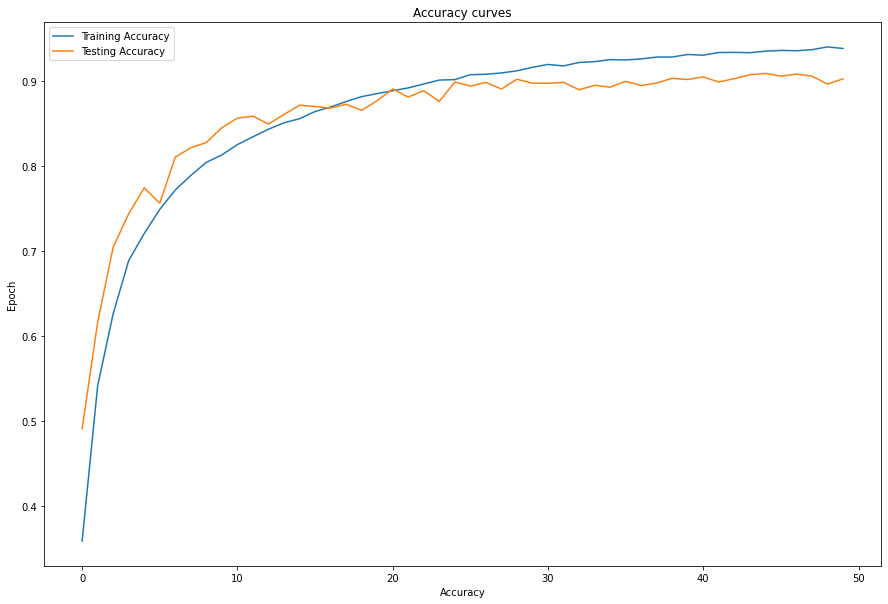

In [0]:
plt.figure(figsize=(15, 10))
ax = plt.subplot(111)
ax.plot(model.stats().train_acc)
ax.plot(model.stats().test_acc)

ax.set(title="Accuracy curves", xlabel="Accuracy", ylabel="Epoch")
ax.legend(['Training Accuracy', 'Testing Accuracy'], loc='best')
plt.savefig("TrainTestAccuracy.png")
plt.show()

# Plot Misclassified Images

In [0]:

len(model.stats().get_misclassified_images())

25

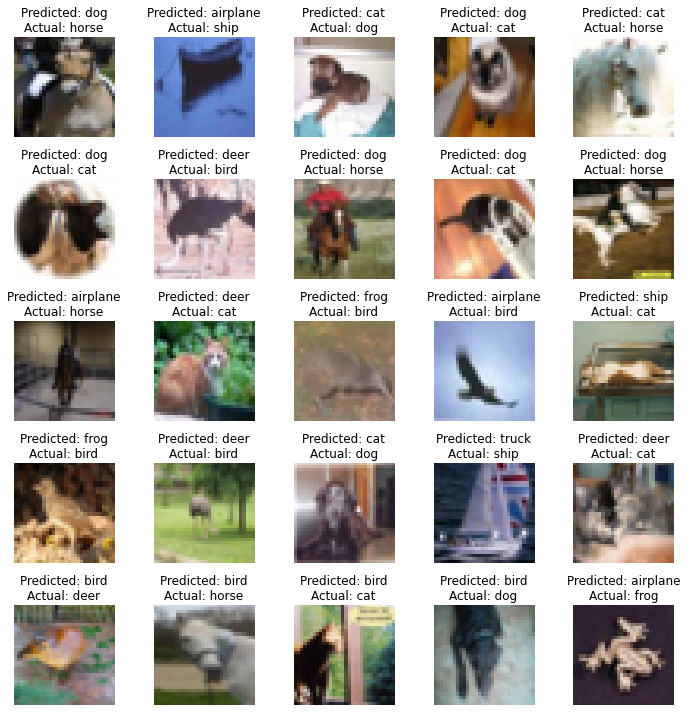

In [0]:
import plots
plots.plot_images(model.stats().get_misclassified_images(), class_names, "misclassified_imgs.png", mean=list(channel_means), std=list(channel_stdevs))


In [0]:
mimages = model.stats().get_misclassified_images()
images = []
target_classes = []
pred_classes = []
for i in mimages:
  images.append(i["img"].cpu())
  target_classes.append(int(i['target']))
  pred_classes.append(int(i['pred']))

In [0]:
print(target_classes)
print(pred_classes)

[7, 8, 5, 3, 7, 3, 2, 7, 3, 7, 7, 3, 2, 2, 3, 2, 2, 5, 8, 3, 4, 7, 3, 5, 6]
[5, 0, 3, 5, 3, 5, 4, 5, 5, 5, 0, 4, 6, 0, 8, 6, 4, 3, 9, 4, 2, 2, 2, 2, 0]


# Implementing **Gradcam** of Misclassified Images

torch.Size([10, 10])
Generating Grad-CAM @layer1
Generating Grad-CAM @layer2
Generating Grad-CAM @layer3
Generating Grad-CAM @layer4


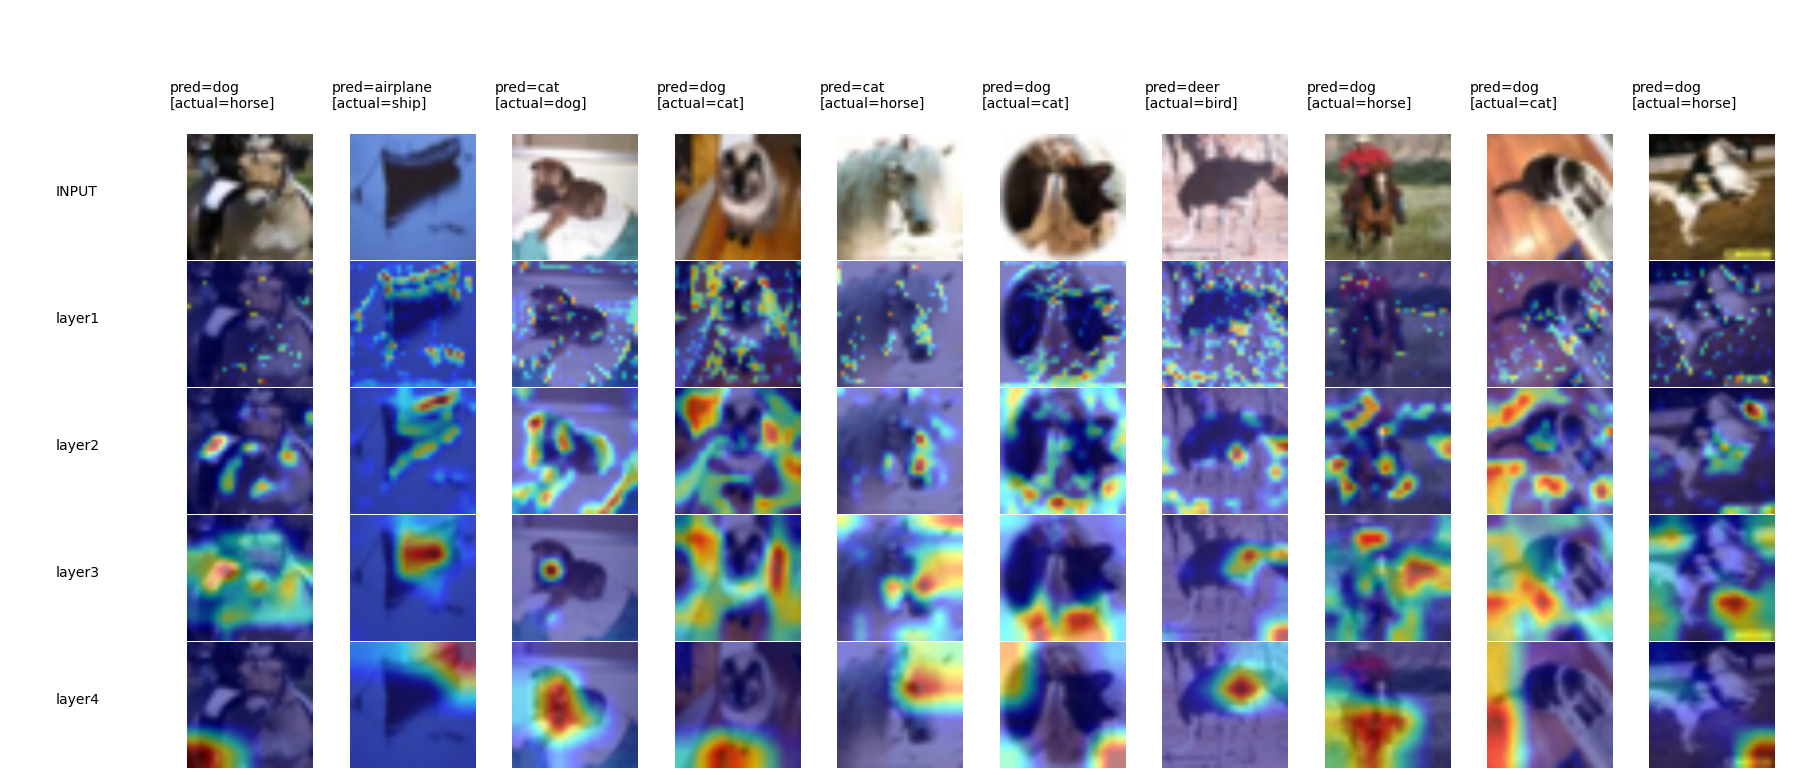

torch.Size([10, 10])
Generating Grad-CAM @layer1
Generating Grad-CAM @layer2
Generating Grad-CAM @layer3
Generating Grad-CAM @layer4


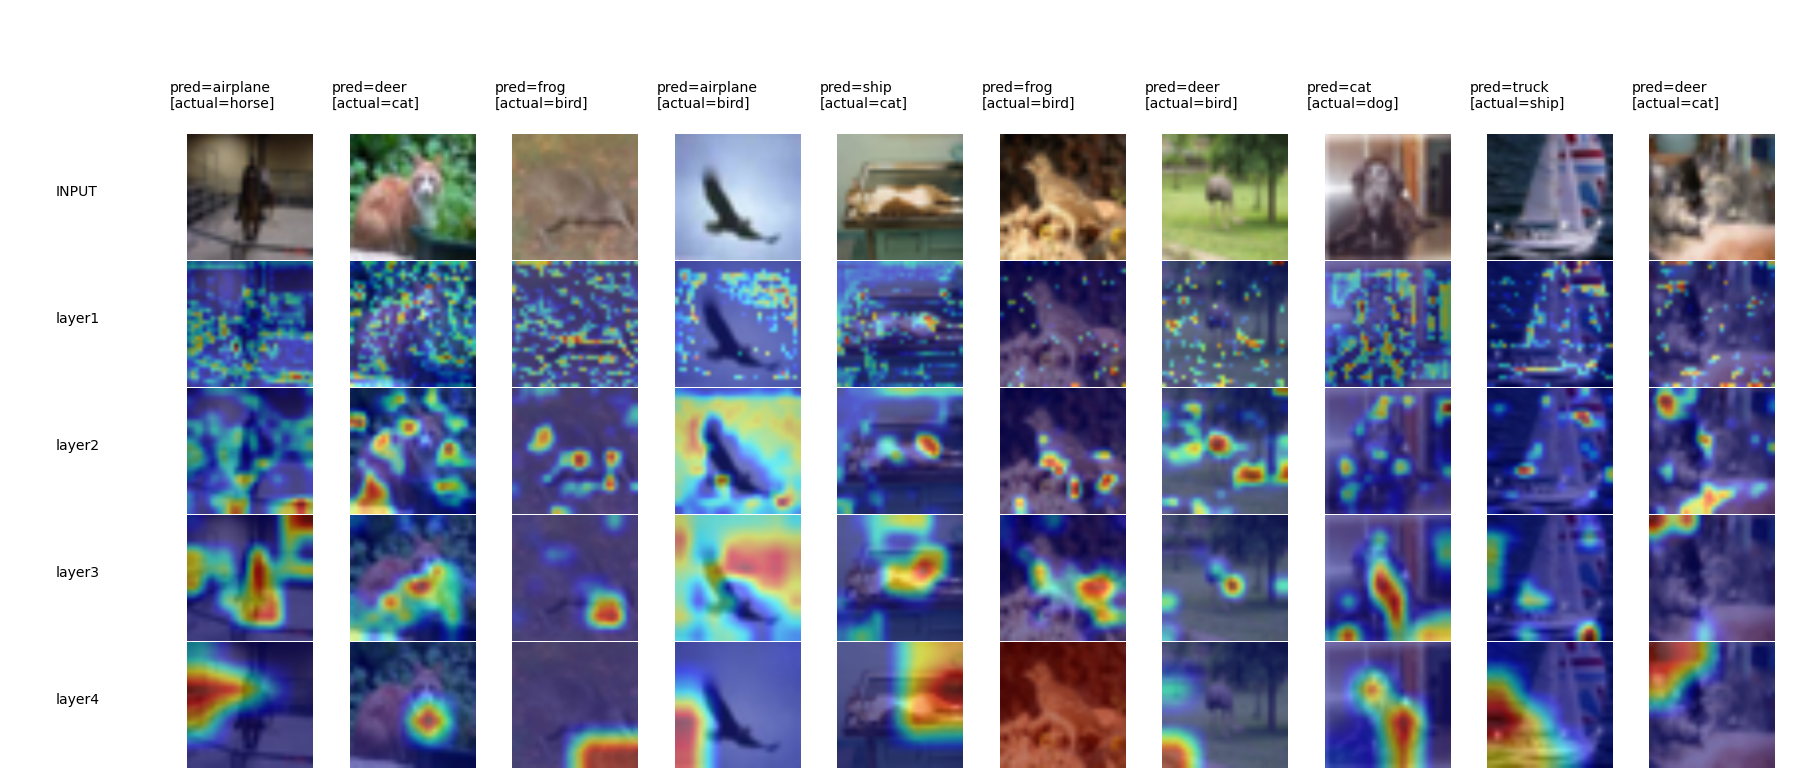

torch.Size([5, 10])
Generating Grad-CAM @layer1
Generating Grad-CAM @layer2
Generating Grad-CAM @layer3
Generating Grad-CAM @layer4


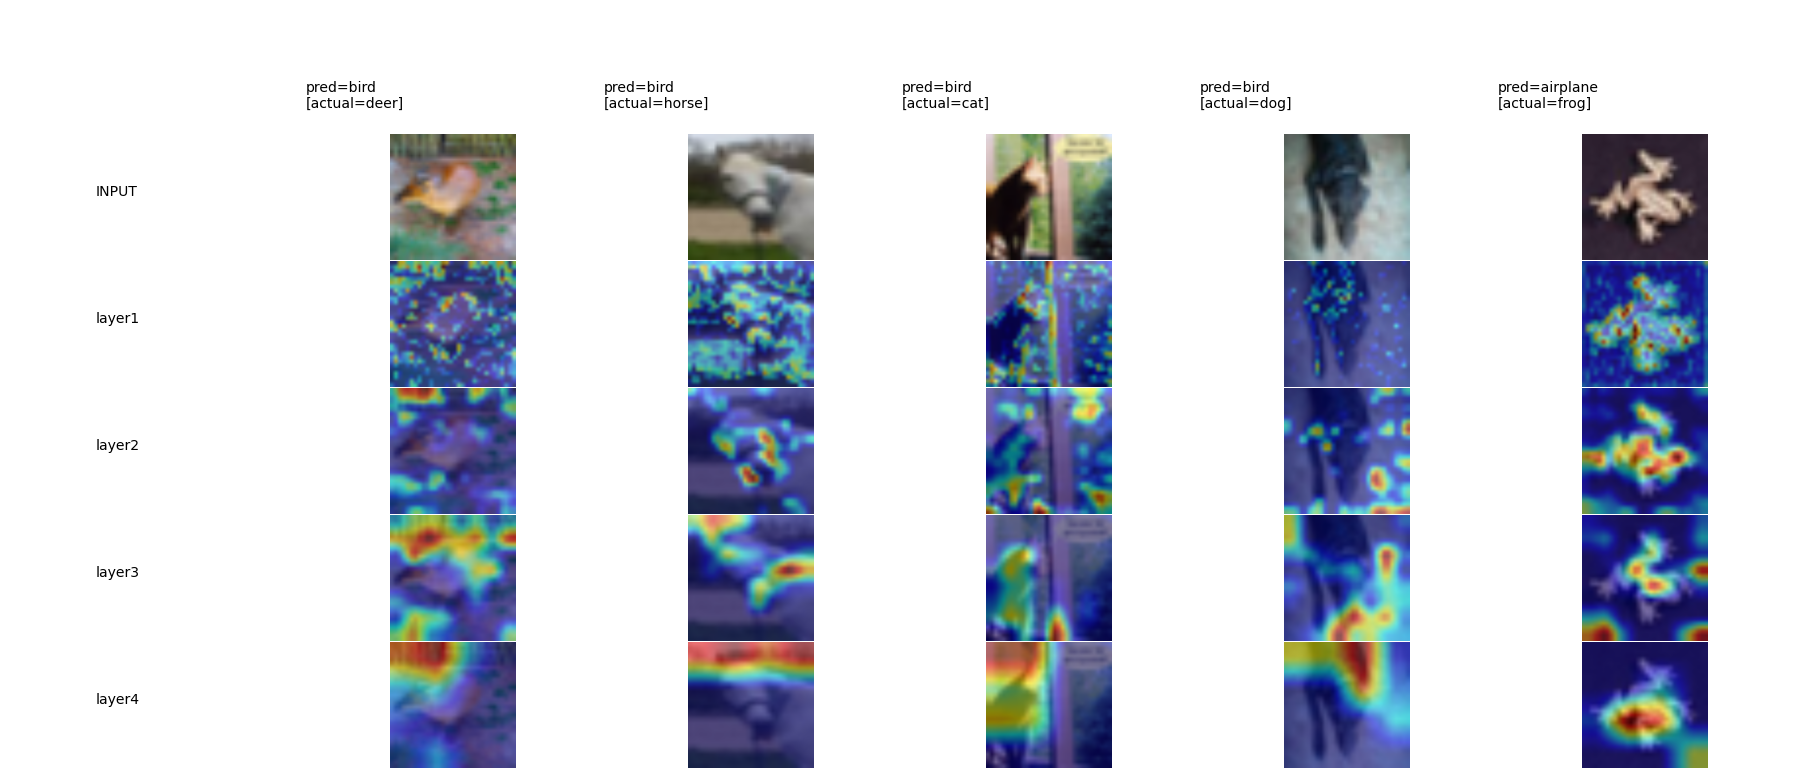

In [0]:
from gradcam import GRADCAM, PLOT
target_layers = ["layer1", "layer2", "layer3", "layer4"]
#Gradcam plot for first 10 misclassified images
gradcam_output, probs, predicted_classes = GRADCAM(images[:10], target_classes[:10], model, target_layers)
PLOT(gradcam_output, images[:10], target_classes[:10], target_layers, class_names, (3, 32, 32), predicted_classes, unnormalize)
#Gradcam plot for 11-20 misclassified images
gradcam_output, probs, predicted_classes = GRADCAM(images[10:20], target_classes[10:20], model, target_layers)
PLOT(gradcam_output, images[10:20], target_classes[10:20], target_layers, class_names, (3, 32, 32), predicted_classes, unnormalize)
#Gradcam plot for 21-25 misclassified images
gradcam_output, probs, predicted_classes = GRADCAM(images[20:], target_classes[20:], model, target_layers)
PLOT(gradcam_output, images[20:], target_classes[20:], target_layers, class_names, (3, 32, 32), predicted_classes, unnormalize)

# Submitted by G Uday Kiran and Srilakshmi V